Calculate flags for every unit:

1. at least 20 completed trials
2. at least 1hz of mean activity during the fixation period
3. each 50-ms time bin during fixation with nonzero mean activity

Flags are calculated based on binned data (to mimic the paper).

Flags are calculated on the dataset with empty trials (no spikes at all during fixation period!)

2 and 3 are calculated on [0, 1000]ms portion of the data

In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
fig_folder = 'E:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fig_drafts\\'
save_folder = 'E:\\projects_q_30_10_2024\\isttc\\results\\monkey\\fixation_period_1000ms\\'

In [3]:
def load_data(area_, verbose_=False):
    # binned data
    results_folder = 'E:\\projects_q_30_10_2024\\isttc\\results\\monkey\\'
    
    csv_data_file = results_folder + 'data_' + area_ + '_fixon_1500ms_fixation_with_empty_binned_50ms.csv'
    with open(csv_data_file, newline='') as f:
        reader = csv.reader(f)
        sua_binned_list = list(reader)
        
    n_binned_spike_trains = len(sua_binned_list)
    print('N spike_trains in {}: {}'.format(area_, n_binned_spike_trains))

    # # CREEPY STUFF BELOW!!!
    # # the data is binned using 1500ms of fixation period but for caluclation they used only 1000 second (why?)
    # # in some trials there are spikes in 1500ms but no spikes in 1000ms, those trials are not removed
    # # here I am removing them
    # sua_binned_list_no_empty = []
    # for idx, trial in enumerate(sua_binned_list):
    #     trial_spikes = np.asarray(trial[3:-1-9]).astype(int) # for 1000 calc
    #     if np.count_nonzero(trial_spikes) == 0:
    #         if verbose_:
    #             print('all 0! i= {}, removing...'.format(idx))
    #     else:
    #         sua_binned_list_no_empty.append(trial)

    sua_binned_list_no_empty = sua_binned_list
    
    n_binned_spike_trains = len(sua_binned_list_no_empty)
    print('N spike_trains in {}: {}'.format(area_, n_binned_spike_trains))
    # END OF CREEPY STUFF
    
    # transform list to an array and to a dataframe 
    sua_binned_array = np.array(sua_binned_list_no_empty)
    sua_binned_array = sua_binned_array[:, :-1-9] # for 1000 calc
    
    bin_cols = ['bin_' + str(i) for i in range(sua_binned_array.shape[1]-3)]
    sua_binned_df = pd.DataFrame(sua_binned_array, columns=['unit_id', 'trial_id','condition_id'] + bin_cols)
    sua_binned_df = sua_binned_df.astype('int')
    
    n_binned_units = len(sua_binned_df['unit_id'].unique())
    print('n units {}'.format(n_binned_units))

    return sua_binned_df, bin_cols

In [ ]:
# sua_pfdl_df, bin_cols = load_data('pfdl', verbose_=False)

# # at least 20 completed trials
# unit_trial_count_df = sua_pfdl_df.groupby(by='unit_id', as_index=False)['trial_id'].count()
# unit_trial_count_df.rename(columns={'trial_id':'n_trials'}, inplace=True)
# unit_trial_count_more20_df = unit_trial_count_df.query('n_trials >= 20').copy()
# n_units_trials_20 = len(unit_trial_count_more20_df)
# units_trials_20 = unit_trial_count_more20_df['unit_id'].values
# #unit_trial_count_more20_df

# sua_pfdl_trials_20_df = sua_pfdl_df[sua_pfdl_df['unit_id'].isin(units_trials_20)].copy()
# print(len(sua_pfdl_trials_20_df['unit_id'].unique()))

# # each 50-ms time bin during fixation with nonzero mean activity
# trial_mean_activity_df = sua_pfdl_trials_20_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()

# # n rows with nans
# n_nans_trial_mean_activity_df = trial_mean_activity_df.isna().any(axis=1).sum()
# print('n rows with nans {}'.format(n_nans_trial_mean_activity_df))

# # n rows with 0
# rows_without_0_unit_id_l = trial_mean_activity_df[(trial_mean_activity_df[bin_cols].values != 0).all(axis=1)]['unit_id'].values.tolist()
# n_units_without_0_bins = len(rows_without_0_unit_id_l)
# print('n rows without 0 bins {}'.format(n_units_without_0_bins))

# sua_pfdl_trials_20_no_0_bins_df = sua_pfdl_trials_20_df[sua_pfdl_trials_20_df['unit_id'].isin(rows_without_0_unit_id_l)].copy()
# print(len(sua_pfdl_trials_20_no_0_bins_df['unit_id'].unique()))

# # at least 1hz of mean activity during the fixation period
# trials_20_no_0_bins_mean_activity_df = sua_pfdl_trials_20_no_0_bins_df.groupby(by='unit_id', as_index=False)[bin_cols].mean()
# trials_20_no_0_bins_mean_activity_df['bins_sum'] = trials_20_no_0_bins_mean_activity_df[bin_cols].sum(axis=1)
# trials_20_no_0_bins_mean_activity_df['fr_hz'] = trials_20_no_0_bins_mean_activity_df['bins_sum']/1 # 1500ms
# units_more_1hz_l = trials_20_no_0_bins_mean_activity_df.query('fr_hz >= 1')['unit_id'].values
# n_units_more_1hz_l = len(units_more_1hz_l)

# sua_pfdl_trials_20_no_0_bins_1hz_df = sua_pfdl_trials_20_no_0_bins_df[sua_pfdl_trials_20_no_0_bins_df['unit_id'].isin(units_more_1hz_l)].copy()
# print(len(sua_pfdl_trials_20_no_0_bins_1hz_df['unit_id'].unique()))

In [4]:
def calculate_constraints_df(sua_binned_df_, bin_cols_):
    # Apply contstraints to dataset
    # more than 20 trials
    dataset_constraints_df = sua_binned_df_.groupby(by='unit_id', as_index=False)['trial_id'].count()
    dataset_constraints_df.rename(columns={'trial_id':'n_trials'}, inplace=True)
    dataset_constraints_df['n_trials_more_20'] = dataset_constraints_df['n_trials'] >= 20
    n_units_more_20_trials = len(dataset_constraints_df.query('n_trials_more_20 == True'))
    print('n units with >= 20 trials {}'.format(n_units_more_20_trials))
    
    # each 50-ms time bin during fixation with nonzero mean activity
    trial_mean_activity_df = sua_binned_df_.groupby(by='unit_id', as_index=False)[bin_cols_].mean()
    # n rows with nans
    n_nans_trial_mean_activity_df = trial_mean_activity_df.isna().any(axis=1).sum()
    print('n rows with nans {}'.format(n_nans_trial_mean_activity_df))
    # n rows with 0
    rows_without_0_unit_id_l = trial_mean_activity_df[(trial_mean_activity_df[bin_cols_].values != 0).all(axis=1)]['unit_id'].values.tolist()
    n_units_without_0_bins = len(rows_without_0_unit_id_l)
    print('n rows without 0 bins {}'.format(n_units_without_0_bins))
    
    non_zero_df = pd.DataFrame(np.vstack((rows_without_0_unit_id_l, np.ones(len(rows_without_0_unit_id_l)))).T.astype(int), 
                               columns=['unit_id', 'no_zero_bins'])
    dataset_constraints_df = dataset_constraints_df.merge(non_zero_df, on='unit_id', how='left')
    dataset_constraints_df['no_zero_bins'] = dataset_constraints_df['no_zero_bins'].fillna(value=0).astype(int)
    
    # at least 1hz of mean activity during the fixation period
    #trials_20_no_0_bins_mean_activity_df = sua_binned_df_.groupby(by='unit_id', as_index=False)[bin_cols_].mean()
    trial_mean_activity_df['bins_sum'] = trial_mean_activity_df[bin_cols_].sum(axis=1)
    trial_mean_activity_df['fr_hz'] = trial_mean_activity_df['bins_sum']/1 # 1000ms
    units_more_1hz_l = trial_mean_activity_df.query('fr_hz >= 1')['unit_id'].values
    print('n rows with more than 1hz {}'.format(len(units_more_1hz_l)))
    
    one_hz_df = pd.DataFrame(np.vstack((units_more_1hz_l, np.ones(len(units_more_1hz_l)))).T.astype(int), 
                               columns=['unit_id', 'one_hz_activity'])
    dataset_constraints_df = dataset_constraints_df.merge(one_hz_df, on='unit_id', how='left')
    dataset_constraints_df['one_hz_activity'] = dataset_constraints_df['one_hz_activity'].fillna(value=0).astype(int)
    return dataset_constraints_df

### Get the data

In [5]:
pfdl_sua_binned_df, pfdl_bin_cols = load_data(area_='pfdl')
pfdl_dataset_constraints_df = calculate_constraints_df(pfdl_sua_binned_df, pfdl_bin_cols)

pfp_sua_binned_df, pfp_bin_cols = load_data(area_='pfp')
pfp_dataset_constraints_df = calculate_constraints_df(pfp_sua_binned_df, pfp_bin_cols)

N spike_trains in pfdl: 47339
N spike_trains in pfdl: 47339
n units 544
n units with >= 20 trials 544
n rows with nans 0
n rows without 0 bins 382
n rows with more than 1hz 391
N spike_trains in pfp: 43677
N spike_trains in pfp: 43677
n units 543
n units with >= 20 trials 541
n rows with nans 0
n rows without 0 bins 332
n rows with more than 1hz 338


In [6]:
# save 
pfdl_dataset_constraints_df.to_pickle(save_folder + 'pfdl_dataset_constraints_df.pkl')
pfp_dataset_constraints_df.to_pickle(save_folder + 'pfp_dataset_constraints_df.pkl')

In [7]:
def get_reduction_df(constrained_data_acf_binned_1000_df):
    one_c = len(constrained_data_acf_binned_1000_df.query('n_trials_more_20 == True'))
    two_c = len(constrained_data_acf_binned_1000_df.query('n_trials_more_20 == 1 and no_zero_bins == 1'))
    three_c = len(constrained_data_acf_binned_1000_df.query('n_trials_more_20 == 1 and no_zero_bins == 1 and one_hz_activity == 1'))
    
    reduction_df = pd.DataFrame(np.vstack((['0', '1', '2', '3'], [len(constrained_data_acf_binned_1000_df), one_c, two_c, three_c])).T, 
                                columns=['n_constraints', 'n_units'])
    reduction_df['n_constraints'] = reduction_df['n_constraints'].astype(int)
    reduction_df['n_units'] = reduction_df['n_units'].astype(int)
    return reduction_df

In [8]:
pfdl_reduction_df = get_reduction_df(pfdl_dataset_constraints_df)
pfdl_reduction_df['area'] = 'pfdl'
pfdl_reduction_df

,n_constraints,n_units,area
0,0,544,pfdl
1,1,544,pfdl
2,2,382,pfdl
3,3,351,pfdl


In [9]:
pfp_reduction_df = get_reduction_df(pfp_dataset_constraints_df)
pfp_reduction_df['area'] = 'pfp'
pfp_reduction_df

,n_constraints,n_units,area
0,0,543,pfp
1,1,541,pfp
2,2,331,pfp
3,3,299,pfp


### Plot

In [10]:
save_fig = True

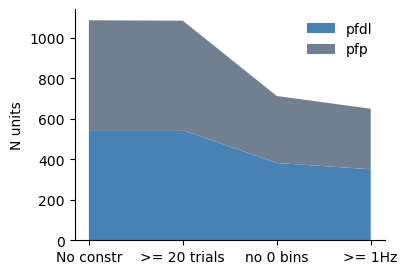

In [11]:
fig, axes = plt.subplots(1,1, figsize=(4,3))

axes.stackplot(pfdl_reduction_df['n_constraints'].values, 
               pfdl_reduction_df['n_units'].values, pfp_reduction_df['n_units'].values, 
               colors =['steelblue', 'slategray'], labels=['pfdl', 'pfp'])

axes.set_xticks([0,1,2,3])
axes.set_xticklabels(['No constr','>= 20 trials','no 0 bins','>= 1Hz'])

axes.set_ylabel('N units')

axes.legend(frameon=False)

sns.despine()

if save_fig:
    fig.savefig(fig_folder + 'constraints_on_data_with_empty_1000.png', bbox_inches='tight')
    fig.savefig(fig_folder + 'constraints_on_data_with_empty_1000.svg', bbox_inches='tight')